In [1]:
import numpy as np
import qmt
import imt
import ring
from imt.utils.view import view
from imt.utils.view import VisOptions
import matplotlib.pyplot as plt
import tree

In [2]:
# LOAD DATA
file = "C:/Users/kubil/Documents/STUDIUM/Master/4_Masterarbeit_Code/IOE-Algo-compare/Daten/IMU/Dict_Frames/S0131_dict_frame.npy"  # noqa: E501
sensors = ["S0333", "S1094", "S0593", "S0994", "S0477"]
data = np.load(file, allow_pickle=True).item()
Hz = 52

In [3]:
# PREPARE DATA
imu_data = {
    i: dict(acc=data[sensors[i]]["acc"], gyr=data[sensors[i]]["gyr_rad"])
    for i in range(5)
}
imu_data = imt.utils.resample(imt.utils.crop_tail(imu_data, Hz), Hz, 100.0)
imu_data[0] = dict(
    acc=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["acc"]),
    gyr=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["gyr"]),
)

`crop_tail`: Crop off at t=182.15384615384616s


In [4]:
rel_method = imt.methods.RING(axes_directions=np.array([1.0, 0, 0]))
graph = [-1, 0, 1, 0, 3]
Ts=0.01
solver = imt.Solver(graph, [imt.methods.VQF(offline=True)] + 
                    #[imt.wrappers.JointTracker1D(imt.wrappers.LPF(imt.wrappers.JointPosition(imt.wrappers.FractualStepping(rel_method, 100), dof_is_1d=True), quat_f_cutoff=2))] * 4, 0.01)
                    [imt.wrappers.JointTracker1D(rel_method)] * 4, Ts=Ts)
qhat, extras = solver.step(
    imu_data
)

In [6]:
print(extras)

{0: {}, 1: {'joint_axis_direction': array([-0.98200111, -0.11973551, -0.14607268]), 'joint_angle_rad': array([ 0.        , -0.1743817 , -0.37615109, ..., -2.44701643,
       -2.45169428, -2.45420832], shape=(18216,))}, 2: {'joint_axis_direction': array([ 0.90385972, -0.3906121 , -0.17452736]), 'joint_angle_rad': array([ 0.        , -0.03950983, -0.0936533 , ..., -0.58099127,
       -0.58082784, -0.58083086], shape=(18216,))}, 3: {'joint_axis_direction': array([ 0.99407333,  0.03014343, -0.10444898]), 'joint_angle_rad': array([0.        , 0.16712999, 0.31170616, ..., 2.0353602 , 2.0358485 ,
       2.03607581], shape=(18216,))}, 4: {'joint_axis_direction': array([0.45649164, 0.87849483, 0.14093336]), 'joint_angle_rad': array([0.        , 0.10012525, 0.12440675, ..., 0.42360586, 0.4242988 ,
       0.42448805], shape=(18216,))}}


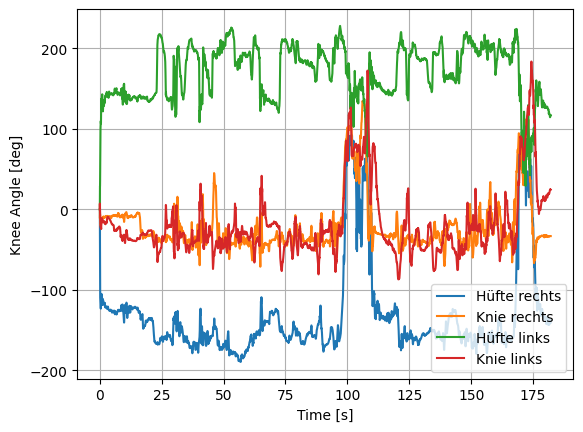

In [9]:
T = qhat[0].shape[0]
ts = np.arange(T)*0.01
plt.plot(ts, np.rad2deg(extras[1]["joint_angle_rad"]), label="Hüfte rechts")
plt.plot(ts, np.rad2deg(extras[2]["joint_angle_rad"]), label="Knie rechts")
plt.plot(ts, np.rad2deg(extras[3]["joint_angle_rad"]), label="Hüfte links")
plt.plot(ts, np.rad2deg(extras[4]["joint_angle_rad"]), label="Knie links")
plt.grid()
plt.legend()
plt.ylabel("Knee Angle [deg]")
plt.xlabel("Time [s]")
plt.show()

In [18]:
# show only the first 10 seconds
extras[1]["joint-center-to-body1"] = np.array([-0.5, 0.15, 0])
extras[3]["joint-center-to-body1"] = np.array([0.05, 0.15, 0])
extras[1]["joint-center-to-body2"] = np.array([0, -0.05, -0.025])
extras[3]["joint-center-to-body2"] = np.array([0, -0.05, -0.025])
extras[2]["joint-center-to-body1"] = np.array([0, 0.05, 0])
extras[2]["joint-center-to-body2"] = np.array([0, -0.05, 0])
extras[4]["joint-center-to-body1"] = np.array([0, 0.05, 0])
extras[4]["joint-center-to-body2"] = np.array([0, -0.05, 0])

In [ ]:


#T = int(10 / Ts)
#pos = np.zeros((T, 3))
pos = np.zeros((qhat[0].shape[0], 3))
pos[:, 2] = 0.5

#qhat_first_10_seconds = tree.map_structure(lambda a: a[:T], qhat)
vis_options = VisOptions(
    #show_floor=True,
    show_stars=False,
    body_xyz_dim=0.03,
    imu_xyz_dim=0.02,
    imu_type="cylinder",
    imu_dim="0.01 0.005",
    imu_color="black",
    #floor_material="beige",
    joint_to_imu_color=[0.5, 0.5, 0.5, 1],
    imu_offset=[0, 0, -0.01],
    show_imu_xyz=False,
)
view(graph,
     qhat, 
     extras, 
     hz=100, 
     global_translation=pos, 
     mode="offscreen",
     #show_floor=True, 
     width=640, 
     height=480, 
     offscreen_mode_options=dict(camid=1, github=True, output_path="C:/Users/kubil/Documents/STUDIUM/Master/4_Masterarbeit_Code/IOE-Algo-compare/Daten/videoSimS0131.gif"), 
     show_every_nth_frame=4,
     )

In [ ]:
pos = np.zeros((qhat[0].shape[0], 3))
pos[:, 2] = 0.05
vis_options = VisOptions(
    show_floor=True,
    show_stars=False,
    body_xyz_dim=0.03,
    imu_xyz_dim=0.02,
    imu_type="cylinder",
    imu_dim="0.01 0.005",
    imu_color="black",
    #floor_material="beige",
    joint_to_imu_color=[0.5, 0.5, 0.5, 1],
    imu_offset=[0, 0, -0.01],
    show_imu_xyz=False,
)
view(
    graph,
    qhat,
    extras,
    hz=100,
    show_every_nth_frame=4,
    global_translation=pos,
    height=720,
    width=1280,
    vis_options=vis_options,
)